In [1]:
from functools import partial

import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import sklearn, sklearn.linear_model
import torch

import loader
from models import MLPClassifier, BinningCalibrator
import utils

split_ratio_test = 0.3
split_ratio_postproc = 0.1  # among all training data

# These seeds control the randomness for the post-process/test split and in
# postprocessing.  It does not affect pre-training data nor the randomness in
# pre-training, i.e., we assume the pre-trained predictor to be fixed.  Results
# will be aggregated over the seeds.
seeds = range(33, 38)

# This seed controls the randomness during pre-training (fixed)
seed_pretrain = 33

# Settings for calibration
n_bins_calib = 100
prior_strength_calib = 1
calibrator_factory = partial(BinningCalibrator,
                             n_bins=n_bins_calib,
                             prior_strength=prior_strength_calib)

max_workers = 32
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

data_dir = "data/acsincome"

In [2]:
## Load ACSIncome dataset from `folktables`

(inputs_df, labels, label_names, groups, group_names) = loader.cache_dataset(
    f"{data_dir}/acsincome2.pkl", lambda: loader.load_acsincome(
        data_dir,
        n_classes=2,
        sensitive_attr='SEX',
    ))
display(loader.dataset_stats(labels, label_names, groups, group_names))

n_classes = len(label_names)
n_groups = len(group_names)

inputs = np.array(inputs_df.values, dtype=np.float32, copy=True)
inputs_df.drop(columns=list(inputs_df.filter(regex=f'^SEX_')), inplace=True)
inputs_u = inputs_df.values.astype(np.float32)

Group,Male,Female
Target,,
<=50K,483923,566510
>50K,382812,231255


In [3]:
## Split data into (test + post-processing) and pre-training sets

(inputs_, inputs_pretrain, inputs_u_, inputs_u_pretrain, labels_,
 labels_pretrain, groups_,
 groups_pretrain) = sklearn.model_selection.train_test_split(
     inputs,
     inputs_u,
     labels,
     groups,
     test_size=(1 - split_ratio_test) * (1 - split_ratio_postproc),
     random_state=seed_pretrain,
 )

# Encode the joint (A, Y) labels by flattening
labels_ay_pretrain = groups_pretrain * n_classes + labels_pretrain

# Normalize data
scaler = sklearn.preprocessing.StandardScaler()
inputs_pretrain = scaler.fit_transform(inputs_pretrain)
inputs_ = scaler.transform(inputs_)

scaler = sklearn.preprocessing.StandardScaler()
inputs_u_pretrain = scaler.fit_transform(inputs_u_pretrain)
inputs_u_ = scaler.transform(inputs_u_)

n_samples = len(inputs)
n_test = int(n_samples * split_ratio_test)

## Logistic regression

In [4]:
# Train attribute-aware p(Y | X) predictor
predictor_y = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute-blind p(A, Y | X) predictor
predictor_u_ay = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print(
    'Binned ECE of attribute-blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_,
                            n_bins=n_bins_calib))

Binned ECE of attribute-blind predictor: 0.16636890400256849


In [5]:
# Precompute P(A, Y | X) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'probas_ay': probas_ay_u_}

Code for post-processing a single model (with precomputed probas):

    postprocessor = postprocess.PostProcessor(
        n_classes,
        n_groups,
        pred_ay_fn=lambda x: x,  # dummy pred_fn
        criterion='sp',
        alpha=alpha,
        seed=seed,
    )
    postprocessor.fit(probas_ay_postproc)
    preds = postprocessor.predict(probas_ay_test)


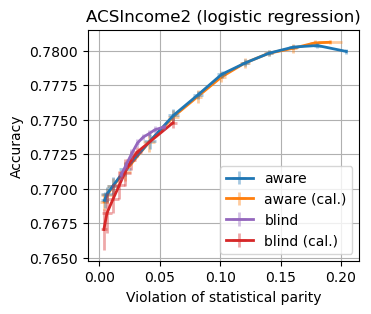

Results for attribute-aware setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.779939  0.000162  0.204323  0.000608
0.180  0.780367  0.000173  0.180478  0.003211
0.160  0.780256  0.000175  0.160661  0.003625
0.140  0.779815  0.000239  0.140567  0.003484
0.120  0.779108  0.000254  0.120769  0.003176
0.100  0.778284  0.000256  0.101278  0.003611
0.080  0.776791  0.000302  0.081540  0.004008
0.060  0.775316  0.000429  0.061336  0.004803
0.040  0.773436  0.000541  0.041731  0.004833
0.020  0.771429  0.000493  0.021501  0.004882
0.010  0.770230  0.000616  0.011423  0.005080
0.005  0.769615  0.000540  0.006267  0.005213
0.001  0.769173  0.000584  0.004287  0.003160

Results for attribute-aware setting with calibration:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.780604  0.000139  0.190954  0.010295
0.180  0.780554  0.000195  0.178272  0.003546
0.160  0.780164  0.000307  0.160221  0.003317
0.140  0.779807  0.000225  0.140311  0.003713
0.120  0.779096  0.000370  0.120326  0.003978
0.100  0.778092  0.000389  0.101082  0.004021
0.080  0.776670  0.000443  0.081304  0.003923
0.060  0.775212  0.000501  0.061234  0.004614
0.040  0.773366  0.000729  0.040989  0.004852
0.020  0.771243  0.000691  0.021090  0.004699
0.010  0.770200  0.000562  0.011236  0.004793
0.005  0.769535  0.000560  0.006434  0.004813
0.001  0.769071  0.000602  0.004114  0.003300

Results for attribute-blind setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.774478  0.000212  0.053829  0.000802
0.030  0.774273  0.000260  0.045968  0.001146
0.025  0.773991  0.000266  0.041167  0.001069
0.020  0.773739  0.000220  0.036245  0.001040
0.015  0.773309  0.000289  0.031512  0.001264
0.010  0.772507  0.000362  0.026519  0.001199
0.005  0.771679  0.000339  0.021851  0.001278
0.001  0.771008  0.000362  0.018017  0.001129

Results for attribute-blind setting with calibration:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.774770  0.000383  0.060833  0.003422
0.030  0.772645  0.000352  0.031143  0.003864
0.025  0.772052  0.000658  0.026192  0.004174
0.020  0.771161  0.000978  0.021063  0.004716
0.015  0.770274  0.001020  0.016582  0.004721
0.010  0.769280  0.001062  0.011402  0.004620
0.005  0.768234  0.001444  0.006264  0.004361
0.001  0.767057  0.001500  0.003739  0.002572

In [6]:
## Post-processing for statistical parity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01,
        0.005, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    print_code=True,
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01,
        0.005, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.03, 0.025, 0.02, 0.015, 0.01, 0.005, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.03, 0.025, 0.02, 0.015, 0.01, 0.005, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_sp',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_sp',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_sp',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_sp',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

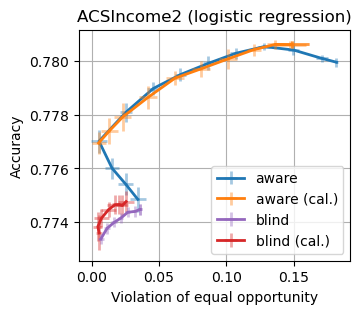

Results for attribute-aware setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.779939  0.000162   0.181835  0.001177
0.200  0.780079  0.000145   0.171142  0.004321
0.180  0.780393  0.000176   0.149894  0.003936
0.160  0.780520  0.000141   0.128126  0.004300
0.140  0.780272  0.000201   0.107095  0.004571
0.120  0.779899  0.000265   0.086722  0.004350
0.100  0.779479  0.000254   0.065872  0.004228
0.080  0.778963  0.000239   0.045705  0.004660
0.060  0.778089  0.000353   0.025585  0.004659
0.040  0.777009  0.000424   0.005465  0.005582
0.020  0.776008  0.000382   0.015175  0.005307
0.010  0.775418  0.000421   0.025269  0.005746
0.001  0.774853  0.000453   0.034280  0.005908

Results for attribute-aware setting with calibration:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.780604  0.000139   0.148511  0.012737
0.200  0.780604  0.000139   0.148511  0.012737
0.180  0.780604  0.000139   0.148511  0.012737
0.160  0.780592  0.000133   0.147576  0.011753
0.140  0.780600  0.000156   0.136355  0.006430
0.120  0.780406  0.000222   0.120415  0.004995
0.100  0.780057  0.000376   0.100940  0.006720
0.080  0.779697  0.000287   0.081396  0.006854
0.060  0.779348  0.000251   0.061896  0.006357
0.040  0.778639  0.000431   0.041952  0.006441
0.020  0.777913  0.000528   0.023192  0.006382
0.010  0.777394  0.000492   0.013160  0.006443
0.001  0.776938  0.000400   0.005140  0.005192

Results for attribute-blind setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.774478  0.000212   0.035940  0.001269
0.030  0.774478  0.000208   0.035910  0.001329
0.025  0.774403  0.000205   0.032104  0.001954
0.020  0.774377  0.000177   0.026925  0.001851
0.015  0.774154  0.000182   0.021599  0.001693
0.010  0.774006  0.000184   0.016909  0.002206
0.005  0.773782  0.000210   0.011493  0.002393
0.001  0.773384  0.000193   0.006818  0.002116

Results for attribute-blind setting with calibration:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.774770  0.000383   0.025590  0.006033
0.030  0.774626  0.000376   0.022748  0.004517
0.025  0.774663  0.000358   0.020509  0.005034
0.020  0.774654  0.000360   0.017425  0.005802
0.015  0.774475  0.000294   0.012595  0.005422
0.010  0.774155  0.000328   0.007314  0.005440
0.005  0.773843  0.000546   0.004604  0.003358
0.001  0.773615  0.000649   0.005547  0.002270

In [7]:
## Post-processing for equal opportunity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01,
        0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01,
        0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.03, 0.025, 0.02, 0.015, 0.01, 0.005, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.03, 0.025, 0.02, 0.015, 0.01, 0.005, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_eopp',
                   'accuracy',
                   label='aware',
                   zorder=10)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_eopp',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=20)
utils.plot_results(ax,
                   df_blind,
                   'delta_eopp',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_eopp',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

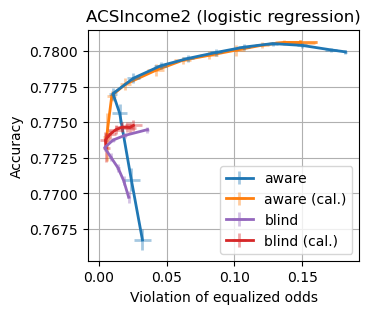

Results for attribute-aware setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.779939  0.000162  0.181835  0.001177
0.200  0.780079  0.000145  0.171142  0.004321
0.180  0.780393  0.000176  0.149894  0.003936
0.160  0.780520  0.000141  0.128126  0.004300
0.140  0.780272  0.000201  0.107095  0.004571
0.120  0.779899  0.000265  0.086722  0.004350
0.100  0.779479  0.000254  0.065872  0.004228
0.080  0.778963  0.000239  0.045705  0.004660
0.060  0.778089  0.000353  0.025585  0.004659
0.040  0.777009  0.000424  0.010483  0.002674
0.020  0.775632  0.000664  0.015419  0.005413
0.010  0.770945  0.000811  0.024036  0.006160
0.001  0.766741  0.000731  0.032187  0.006274

Results for attribute-aware setting with calibration:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.780604  0.000139  0.148511  0.012737
0.200  0.780604  0.000139  0.148511  0.012737
0.180  0.780604  0.000139  0.148511  0.012737
0.160  0.780592  0.000133  0.147576  0.011753
0.140  0.780600  0.000156  0.136355  0.006430
0.120  0.780406  0.000222  0.120415  0.004995
0.100  0.780057  0.000376  0.100940  0.006720
0.080  0.779697  0.000287  0.081396  0.006854
0.060  0.779347  0.000252  0.061894  0.006356
0.040  0.778639  0.000431  0.041952  0.006441
0.020  0.777665  0.000428  0.019604  0.004265
0.010  0.776870  0.000352  0.009626  0.003267
0.001  0.773979  0.001680  0.005801  0.002853

Results for attribute-blind setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.774478  0.000212  0.035940  0.001269
0.030  0.774068  0.000187  0.019123  0.001638
0.025  0.773746  0.000162  0.010531  0.001360
0.020  0.773209  0.000224  0.004324  0.000782
0.015  0.772573  0.000269  0.008726  0.000826
0.010  0.771788  0.000278  0.014222  0.001396
0.005  0.770879  0.000312  0.018440  0.001090
0.001  0.769742  0.000396  0.022017  0.001236

Results for attribute-blind setting with calibration:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.774770  0.000383  0.025590  0.006033
0.030  0.774626  0.000376  0.022748  0.004517
0.025  0.774663  0.000358  0.020509  0.005034
0.020  0.774654  0.000360  0.017425  0.005802
0.015  0.774475  0.000294  0.012595  0.005422
0.010  0.774155  0.000328  0.008392  0.004079
0.005  0.773758  0.000559  0.004903  0.003723
0.001  0.773195  0.000983  0.005455  0.002649

In [8]:
## Post-processing for equalized odds

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01,
        0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01,
        0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.03, 0.025, 0.02, 0.015, 0.01, 0.005, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.03, 0.025, 0.02, 0.015, 0.01, 0.005, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_eo',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_eo',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_eo',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_eo',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

## Gradient boosting decision tree

In [9]:
# Train attribute-aware p(Y | X) predictor
predictor_y = lightgbm.LGBMClassifier(random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute-blind p(A, Y | X) predictor
predictor_u_ay = lightgbm.LGBMClassifier(random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print(
    'Binned ECE of attribute-blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_,
                            n_bins=n_bins_calib))

Binned ECE of attribute-blind predictor: 0.13074037905779953


In [10]:
# Precompute P(A, Y | X) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'probas_ay': probas_ay_u_}

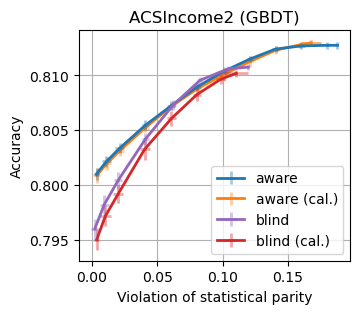

Results for attribute-aware setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.812750  0.000308  0.187952  0.000441
0.180  0.812749  0.000300  0.180165  0.001926
0.160  0.812691  0.000303  0.160287  0.002572
0.140  0.812407  0.000303  0.140489  0.002324
0.120  0.811493  0.000268  0.120848  0.002538
0.100  0.810371  0.000284  0.100902  0.002316
0.080  0.808966  0.000339  0.080573  0.002681
0.060  0.807250  0.000396  0.060812  0.002934
0.040  0.805464  0.000425  0.040934  0.003050
0.020  0.803347  0.000441  0.021079  0.003602
0.010  0.802146  0.000542  0.011033  0.003713
0.001  0.801018  0.000546  0.003461  0.001873

Results for attribute-aware setting with calibration:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.812970  0.000242  0.167302  0.007651
0.180  0.812970  0.000242  0.167302  0.007651
0.160  0.812795  0.000300  0.159118  0.002554
0.140  0.812309  0.000381  0.140782  0.002070
0.120  0.811270  0.000537  0.120926  0.002319
0.100  0.810097  0.000639  0.101086  0.002695
0.080  0.808797  0.000367  0.080820  0.002977
0.060  0.807177  0.000338  0.060626  0.002906
0.040  0.805224  0.000392  0.040775  0.003063
0.020  0.803124  0.000459  0.021159  0.003319
0.010  0.801975  0.000585  0.011477  0.003252
0.001  0.800874  0.000673  0.003546  0.002563

Results for attribute-blind setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.810754  0.000253  0.119561  0.000548
0.100  0.810607  0.000268  0.104370  0.002249
0.080  0.809555  0.000331  0.082660  0.002470
0.060  0.807275  0.000467  0.061935  0.002494
0.040  0.804187  0.000565  0.040863  0.002710
0.020  0.800447  0.000779  0.020140  0.003044
0.010  0.798210  0.000836  0.009331  0.003397
0.001  0.795997  0.000925  0.002099  0.002522

Results for attribute-blind setting with calibration:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.810185  0.000337  0.110368  0.009223
0.100  0.809652  0.000442  0.098547  0.003550
0.080  0.808250  0.000627  0.080246  0.002929
0.060  0.806072  0.000703  0.060825  0.003536
0.040  0.803261  0.001026  0.040284  0.003840
0.020  0.799182  0.000846  0.019993  0.003811
0.010  0.797170  0.000932  0.010234  0.004018
0.001  0.795015  0.000968  0.003542  0.001827

In [11]:
## Post-processing for statistical parity

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_sp',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_sp',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_sp',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_sp',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

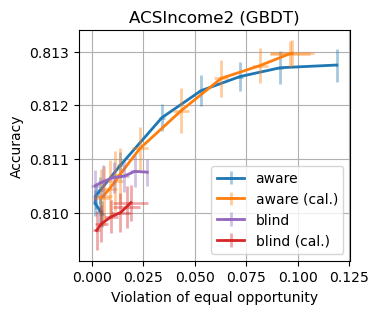

Results for attribute-aware setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.812750  0.000308   0.118865  0.000739
0.100  0.812699  0.000305   0.091500  0.001192
0.080  0.812535  0.000278   0.071891  0.001311
0.060  0.812272  0.000287   0.053015  0.001434
0.040  0.811770  0.000246   0.033987  0.001468
0.020  0.810880  0.000244   0.013766  0.001431
0.010  0.810416  0.000254   0.004006  0.001414
0.008  0.810315  0.000243   0.001960  0.001325
0.005  0.810179  0.000248   0.001440  0.000950
0.002  0.810034  0.000242   0.003977  0.001394
0.001  0.809979  0.000246   0.004878  0.001353

Results for attribute-aware setting with calibration:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.812970  0.000242   0.097308  0.010709
0.100  0.812964  0.000243   0.096386  0.009701
0.080  0.812741  0.000334   0.081750  0.004001
0.060  0.812501  0.000343   0.062799  0.003392
0.040  0.811900  0.000423   0.043377  0.003902
0.020  0.811195  0.000398   0.023281  0.003809
0.010  0.810704  0.000506   0.013482  0.003974
0.008  0.810583  0.000561   0.011375  0.003915
0.005  0.810446  0.000535   0.008567  0.003792
0.002  0.810316  0.000547   0.005704  0.003947
0.001  0.810281  0.000536   0.004616  0.003995

Results for attribute-blind setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.810754  0.000253   0.026850  0.000505
0.020  0.810768  0.000300   0.020757  0.002344
0.015  0.810679  0.000292   0.015621  0.002334
0.010  0.810657  0.000293   0.010702  0.001995
0.005  0.810575  0.000312   0.005216  0.002117
0.001  0.810500  0.000302   0.001531  0.001758

Results for attribute-blind setting with calibration:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.810185  0.000337   0.018913  0.008499
0.020  0.810109  0.000389   0.016857  0.006487
0.015  0.810000  0.000370   0.013848  0.004609
0.010  0.809921  0.000309   0.009258  0.003458
0.005  0.809793  0.000349   0.004609  0.003063
0.001  0.809667  0.000368   0.002260  0.001601

In [12]:
## Post-processing for equal opportunity

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.008, 0.005, 0.002, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.008, 0.005, 0.002, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.02, 0.015, 0.01, 0.005, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.02, 0.015, 0.01, 0.005, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_eopp',
                   'accuracy',
                   label='aware',
                   zorder=10)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_eopp',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=20)
utils.plot_results(ax,
                   df_blind,
                   'delta_eopp',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_eopp',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

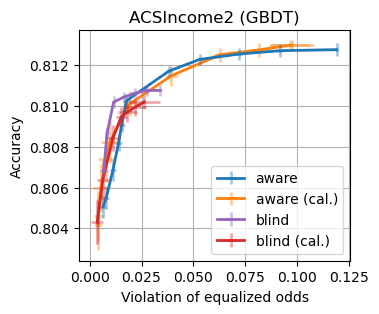

Results for attribute-aware setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.812750  0.000308  0.118865  0.000739
0.100  0.812699  0.000305  0.091500  0.001192
0.080  0.812535  0.000278  0.071891  0.001311
0.060  0.812272  0.000287  0.053015  0.001434
0.040  0.811700  0.000230  0.038170  0.001611
0.020  0.810247  0.000283  0.017715  0.001754
0.010  0.809085  0.000365  0.015484  0.001386
0.008  0.808200  0.000399  0.013975  0.001577
0.005  0.806842  0.000512  0.011228  0.001417
0.002  0.805510  0.000583  0.008046  0.001345
0.001  0.805062  0.000541  0.006518  0.001275

Results for attribute-aware setting with calibration:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.812970  0.000242  0.097308  0.010709
0.100  0.812964  0.000243  0.096386  0.009701
0.080  0.812741  0.000334  0.081750  0.004001
0.060  0.812501  0.000343  0.062799  0.003392
0.040  0.811475  0.000495  0.039377  0.002967
0.020  0.810114  0.000601  0.019596  0.003346
0.010  0.808240  0.001025  0.009739  0.004006
0.008  0.807412  0.001145  0.007921  0.003912
0.005  0.805973  0.001180  0.005374  0.003705
0.002  0.804608  0.001218  0.004199  0.002036
0.001  0.804179  0.001251  0.004169  0.001966

Results for attribute-blind setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.810754  0.000253  0.033849  0.000847
0.025  0.810752  0.000255  0.027449  0.001533
0.020  0.810621  0.000255  0.021971  0.001330
0.015  0.810433  0.000259  0.016539  0.001148
0.010  0.810177  0.000298  0.011540  0.000588
0.005  0.808658  0.000254  0.008395  0.001001
0.001  0.806808  0.000289  0.006832  0.001794

Results for attribute-blind setting with calibration:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.810185  0.000337  0.026285  0.007420
0.025  0.809919  0.000400  0.021626  0.005379
0.020  0.809681  0.000452  0.018108  0.004591
0.015  0.809472  0.000483  0.015294  0.002711
0.010  0.808432  0.000625  0.011243  0.003269
0.005  0.806373  0.000974  0.006371  0.002911
0.001  0.804292  0.001079  0.003673  0.002760

In [13]:
## Post-processing for equalized odds

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.008, 0.005, 0.002, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.008, 0.005, 0.002, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.025, 0.02, 0.015, 0.01, 0.005, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.025, 0.02, 0.015, 0.01, 0.005, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_eo',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_eo',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_eo',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_eo',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

## ReLU network

In [14]:
# Train attribute-aware p(Y | X) predictor
predictor_y = MLPClassifier(hidden_layer_sizes=(500, 200, 100),
                            activation=torch.nn.ReLU(),
                            n_classes=n_classes,
                            n_epochs=20,
                            batch_size=128,
                            lr=1e-3,
                            gamma=0.8,
                            device=device,
                            random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute-blind p(A, Y | X) predictor
predictor_u_ay = MLPClassifier(hidden_layer_sizes=(500, 200, 100),
                               activation=torch.nn.ReLU(),
                               n_classes=n_groups * n_classes,
                               n_epochs=20,
                               batch_size=128,
                               lr=1e-3,
                               gamma=0.8,
                               device=device,
                               random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print(
    'Binned ECE of attribute-blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_,
                            n_bins=n_bins_calib))

Binned ECE of attribute-blind predictor: 0.12583087337739413


In [15]:
# Precompute P(A, Y | X) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'probas_ay': probas_ay_u_}

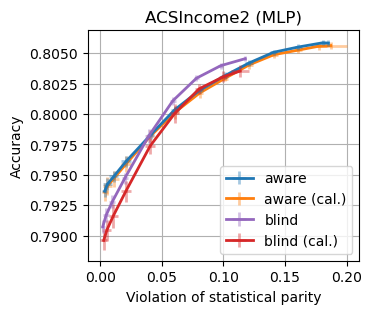

Results for attribute-aware setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.805841  0.000222  0.185219  0.000395
0.180  0.805870  0.000209  0.180803  0.002189
0.160  0.805522  0.000211  0.160925  0.002639
0.140  0.805088  0.000218  0.140750  0.002974
0.120  0.804205  0.000253  0.120781  0.002968
0.100  0.803150  0.000282  0.100926  0.003018
0.080  0.801960  0.000208  0.080690  0.003015
0.060  0.800370  0.000268  0.060557  0.002967
0.040  0.798287  0.000342  0.040829  0.003096
0.020  0.796095  0.000454  0.020755  0.003829
0.010  0.794866  0.000450  0.010889  0.003791
0.005  0.794212  0.000503  0.005596  0.003845
0.001  0.793666  0.000516  0.003501  0.001805

Results for attribute-aware setting with calibration:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.805638  0.000312  0.187186  0.013160
0.180  0.805590  0.000298  0.177709  0.006809
0.160  0.805265  0.000272  0.160713  0.002843
0.140  0.804890  0.000312  0.141059  0.002944
0.120  0.804048  0.000328  0.120879  0.003274
0.100  0.802923  0.000217  0.100930  0.002984
0.080  0.801741  0.000430  0.080747  0.002924
0.060  0.800142  0.000559  0.060613  0.002990
0.040  0.798179  0.000486  0.040567  0.003281
0.020  0.795882  0.000665  0.020725  0.004057
0.010  0.794669  0.000645  0.010689  0.004080
0.005  0.794058  0.000747  0.005719  0.003936
0.001  0.793601  0.000730  0.003600  0.002301

Results for attribute-blind setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.804561  0.000207  0.117689  0.000559
0.100  0.803982  0.000261  0.097744  0.002170
0.080  0.802953  0.000239  0.078057  0.002271
0.060  0.801093  0.000344  0.058844  0.002261
0.040  0.798209  0.000560  0.039394  0.002755
0.020  0.794701  0.000447  0.019735  0.002429
0.010  0.792780  0.000535  0.009647  0.002413
0.005  0.791670  0.000561  0.004641  0.002534
0.001  0.790728  0.000546  0.001903  0.001513

Results for attribute-blind setting with calibration:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.803539  0.000469  0.113419  0.007421
0.100  0.803054  0.000452  0.099504  0.003053
0.080  0.802080  0.000430  0.080240  0.003348
0.060  0.800049  0.000756  0.060379  0.003844
0.040  0.797372  0.000637  0.040413  0.003949
0.020  0.793631  0.000889  0.020586  0.004083
0.010  0.791605  0.000972  0.010410  0.003809
0.005  0.790446  0.000872  0.005219  0.003789
0.001  0.789596  0.000806  0.002677  0.002717

In [16]:
## Post-processing for statistical parity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01,
        0.005, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01,
        0.005, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.005, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.005, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_sp',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_sp',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_sp',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_sp',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (MLP)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

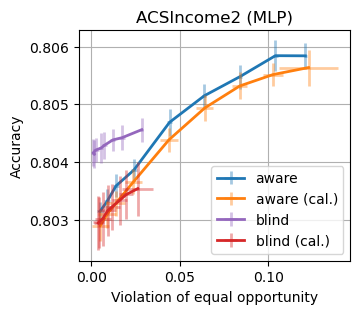

Results for attribute-aware setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.805841  0.000222   0.120918  0.000721
0.100  0.805844  0.000268   0.104029  0.001409
0.080  0.805480  0.000208   0.083970  0.001277
0.060  0.805148  0.000200   0.063865  0.001238
0.040  0.804688  0.000232   0.044266  0.001542
0.020  0.803860  0.000191   0.024109  0.001614
0.010  0.803585  0.000198   0.014027  0.001756
0.005  0.803315  0.000213   0.008979  0.001852
0.001  0.803146  0.000153   0.005010  0.001963

Results for attribute-aware setting with calibration:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.805638  0.000312   0.122737  0.016681
0.100  0.805516  0.000205   0.102678  0.005854
0.080  0.805319  0.000234   0.083902  0.004178
0.060  0.804938  0.000232   0.064207  0.004864
0.040  0.804385  0.000206   0.043923  0.005051
0.020  0.803655  0.000216   0.023840  0.004893
0.010  0.803281  0.000210   0.013874  0.005385
0.005  0.803090  0.000237   0.008849  0.005223
0.001  0.802897  0.000265   0.005166  0.004873

Results for attribute-blind setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.804561  0.000207   0.028576  0.000732
0.020  0.804421  0.000218   0.017393  0.001581
0.015  0.804383  0.000193   0.012272  0.001442
0.010  0.804288  0.000235   0.007387  0.001382
0.008  0.804243  0.000255   0.005594  0.001268
0.005  0.804209  0.000210   0.002713  0.001430
0.002  0.804159  0.000237   0.001135  0.000959
0.001  0.804137  0.000236   0.001736  0.000606

Results for attribute-blind setting with calibration:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.803539  0.000469   0.026326  0.008841
0.020  0.803436  0.000429   0.019846  0.003958
0.015  0.803333  0.000420   0.016021  0.004050
0.010  0.803217  0.000404   0.011574  0.004547
0.008  0.803159  0.000440   0.009402  0.004687
0.005  0.803016  0.000464   0.006519  0.004589
0.002  0.802953  0.000448   0.004248  0.003266
0.001  0.802941  0.000471   0.003998  0.002431

In [17]:
## Post-processing for equal opportunity

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.005, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.005, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.02, 0.015, 0.01, 0.008, 0.005, 0.002, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.02, 0.015, 0.01, 0.008, 0.005, 0.002, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_eopp',
                   'accuracy',
                   label='aware',
                   zorder=10)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_eopp',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=20)
utils.plot_results(ax,
                   df_blind,
                   'delta_eopp',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_eopp',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (MLP)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

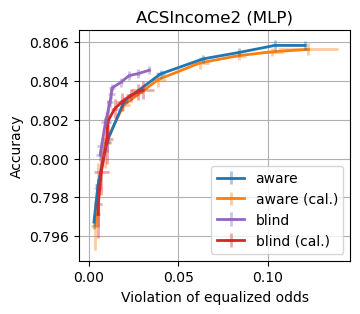

Results for attribute-aware setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.805841  0.000222  0.120918  0.000721
0.100  0.805844  0.000268  0.104029  0.001409
0.080  0.805480  0.000208  0.083970  0.001277
0.060  0.805148  0.000200  0.063865  0.001238
0.040  0.804370  0.000201  0.040023  0.002357
0.020  0.802968  0.000207  0.019687  0.002114
0.010  0.800845  0.000512  0.009929  0.002228
0.005  0.798612  0.000338  0.004963  0.001818
0.001  0.796726  0.000363  0.002757  0.000503

Results for attribute-aware setting with calibration:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.805638  0.000312  0.122737  0.016681
0.100  0.805516  0.000205  0.102678  0.005854
0.080  0.805319  0.000234  0.083902  0.004178
0.060  0.804937  0.000298  0.062010  0.004940
0.040  0.804082  0.000366  0.038830  0.004393
0.020  0.802755  0.000277  0.019281  0.003796
0.010  0.800785  0.001300  0.009159  0.002858
0.005  0.798454  0.001298  0.004894  0.002132
0.001  0.796533  0.001271  0.003533  0.002176

Results for attribute-blind setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.804561  0.000207  0.033710  0.000582
0.030  0.804387  0.000229  0.027444  0.001252
0.025  0.804286  0.000237  0.022421  0.001206
0.020  0.803928  0.000215  0.017692  0.001308
0.015  0.803651  0.000185  0.012883  0.001517
0.010  0.803337  0.000252  0.012432  0.001840
0.008  0.802899  0.000215  0.011725  0.001703
0.005  0.801877  0.000236  0.009185  0.002317
0.002  0.800647  0.000303  0.007028  0.002327
0.001  0.800189  0.000292  0.006278  0.002475

Results for attribute-blind setting with calibration:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.803539  0.000469  0.030004  0.006455
0.030  0.803446  0.000426  0.027440  0.002836
0.025  0.803268  0.000349  0.023356  0.002943
0.020  0.802929  0.000459  0.018314  0.003304
0.015  0.802566  0.000498  0.014311  0.002094
0.010  0.801910  0.001131  0.010446  0.001589
0.008  0.800996  0.001266  0.009983  0.003422
0.005  0.799281  0.001152  0.006820  0.004151
0.002  0.797645  0.001132  0.005164  0.002115
0.001  0.797110  0.001222  0.005100  0.001215

In [18]:
## Post-processing for equalized odds

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.005, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.005, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.03, 0.025, 0.02, 0.015, 0.01, 0.008, 0.005, 0.002, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.03, 0.025, 0.02, 0.015, 0.01, 0.008, 0.005, 0.002, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_eo',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_eo',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_eo',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_eo',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("ACSIncome2 (MLP)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)